# Extensiones para Python con ctypes

Se mostrarán ejemplos de como llamar funciones implementadas en C, y compiladas con `gcc` desde Python con el módulo `ctypes`.

Lo primero es invocar el módulo `ctypes`

In [1]:
import ctypes

## Primer ejemplo

El primer ejemplo consistirá en una función que suma dos números enteros.

### Codificación

Con esta celda mágica se crea el archivo `suma_int.c`

In [2]:
%%file suma_int.c
int suma_int(int a, int b) {
    return a+b;
}

Writing suma_int.c


Ahora toca crear el *object file*

In [3]:
! gcc -c suma_int.c

Luego, toca crear la *shared library*

In [4]:
! gcc -shared suma_int.o -o suma_int.so

Ahora se procederá a hacer una función que configura nuestra *shared library* con el módulo de `ctypes` para poder usarlo desde `python`

In [5]:
def ctypes_suma_int():
    # ruta de la shared library
    lib = ctypes.CDLL('./suma_int.so')
    
    # tipo de los argumentos
    lib.suma_int.argtypes = [ctypes.c_int, ctypes.c_int]
    
    # tipo de la salida
    lib.suma_int.restype  = ctypes.c_int
    
    # se devuelve la función configurada
    return lib.suma_int

In [6]:
# instancia de la funcion
c_suma_int = ctypes_suma_int()

### Prueba de funcionalidad `suma_int`

Por lo pronto se realizarán pruebas individuales para ver si nuestra función tiene el comportamiento esperado

In [7]:
c_suma_int(10, 5)

15

In [8]:
c_suma_int(20, 15)

35

In [9]:
c_suma_int(50, 25)

75

## Segundo ejemplo

El segundo ejemplo tratará de elevar un número a un determinado exponente. 

### Codificación

Se considera a ambos argumentos como double porque así se puede calcular, por ejemplo, potencias de Pi o del número de Euler, o también calcular fracciones. En consecuencia, el resultado también es double. 

In [10]:
%%file num_exp.c
#include <math.h>
double num_exp(double a, double b){
    return pow(a,b);
}

Writing num_exp.c


Para crear el object file

In [11]:
! gcc -c num_exp.c -lm

Para crear la shared library

In [12]:
! gcc -shared num_exp.o -o num_exp.so

Enlace con Python

In [13]:
def ctypes_num_exp():
    # indicar la ruta de la shared library
    libfile = './num_exp.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.num_exp.argtypes = [ctypes.c_double, ctypes.c_double]

    # tipo de dato del resultado
    lib.num_exp.restype = ctypes.c_double
    
    # funcion configurada
    return lib.num_exp

In [14]:
c_num_exp = ctypes_num_exp()

### Prueba de funcionalidad `num_exp`

También se realizarán pruebas individuales para ver si la función tiene el comportamiento esperado

In [15]:
c_num_exp(2, 3)

8.0

In [16]:
c_num_exp(2, 0.5)

1.4142135623730951

In [17]:
c_num_exp(3, 0.5)

1.7320508075688772

### Prueba de precisión de `num_exp`

Si fuera necesario ver que tan preciso es el cálculo presentado se puede **medir el error relativo** del resultado obtenido por nuestra función respecto de una referencia. Para los ejemplos mostrados se medirá respecto del cálculo realizado por Python.

In [18]:
res = c_num_exp(2, 0.5)

In [19]:
ref = 2 ** 0.5

In [20]:
err_rel = abs(ref - res) / abs(ref)

In [21]:
err_rel

0.0

Se obtuvo un error relativo de `0.0`. Esto significa que el valor calculado por nuestra función idéntico al de Python.

## Tercer ejemplo

El tercer ejemplo consistirá en la implementación de algoritmo de ordenamiento "Burbuja". En esta presentación se asumirá que se opera sobre elementos que son todos enteros, y los elemtos serán ordenados de menor a mayor.

### Codificación

In [22]:
%%file ord_burbuja_int.c
void ord_burbuja_int(int* arr, int size){
    int i, j, temp;
    for (i = 0; i < size-1; i++) {
        for (j = 0; j < size-1-i; j++) {
            if (arr[j] > arr[j+1]) {
                temp = arr[j];
                arr[j] = arr[j+1];
                arr[j+1] = temp;
            }
        }
    }
}

Writing ord_burbuja_int.c


Crear el *object file*

In [23]:
! gcc -c ord_burbuja_int.c

Crear la *shared library*

In [24]:
! gcc -shared ord_burbuja_int.o -o ord_burbuja_int.so

Por estar usando arreglos, se hace necesario invocar el módulo `numpy`

In [25]:
import numpy

In [26]:
def ctypes_ord_burbuja_int():
    # indicar la ruta de la shared library
    libfile = './ord_burbuja_int.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.ord_burbuja_int.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        ctypes.c_int
    ]
    
    # funcion configurada
    return lib.ord_burbuja_int

In [27]:
c_ord_burbuja_int = ctypes_ord_burbuja_int()

### Prueba de funcionalidad de `ord_burbuja_int`

Como esta función opera sobre arreglos con números enteros, lo primero es generar un arreglo con números enteros.

In [28]:
arr = numpy.asarray([9, 5, 4, 3, 1, 7, 2, 8]).astype(numpy.int32)

In [29]:
arr

array([9, 5, 4, 3, 1, 7, 2, 8], dtype=int32)

El tamaño del arreglo se obtiene con el propio arreglo

In [30]:
arr.size

8

In [31]:
c_ord_burbuja_int(arr, arr.size)

7

No se deje confundir por el resultado anterior. Se observa que imprime un 7, pero no tiene nada que ver. Si usted recuerda, nuestra función de ordenamiento operaba sobre el propio arreglo, esto significa que para observar nuestro resultado tendríamos que ver como quedó el arreglo luego de ejecutar la función.

In [32]:
arr

array([1, 2, 3, 4, 5, 7, 8, 9], dtype=int32)

Como puede notar, los elementos de `arr` ya se encuentran en orden de menor a mayor.

### Prueba de precisión de `ord_burbuja_int`

Para medir la precisión de nuestra implementación, lo primero sería tener una función de referencia. Para esto se implementará la misma función que se hizo en C, en Python, y luego se compararán los resultados.



In [33]:
l = numpy.asarray([9, 5, 4, 3, 1, 7, 2, 8]).astype(numpy.int32)

Esta función se llamará `py_ord_burbuja_int`

In [34]:
def py_ord_burbuja_int(arr):
    n = len(arr)
    for i in range(n):
        for j in range(n-i-1):
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]


Usamos la función que hemos hecho en Python sobre nuestro arreglo `l`

In [35]:
py_ord_burbuja_int(l)

El arreglo ordenado queda así

In [36]:
l

array([1, 2, 3, 4, 5, 7, 8, 9], dtype=int32)

¿Cómo se mide el error relativo entre dos arreglos? El módulo `numpy` nos proporciona un sub-módulo llamado `linalg` que, al mismo tiempo, nos brinda la función `norm`. Con esta función se puede medir el error relativo entre dos arreglos.

In [37]:
from numpy import linalg as LA

In [38]:
arr = numpy.asarray([9, 5, 4, 3, 1, 7, 2, 8]).astype(numpy.int32)

In [39]:
c_ord_burbuja_int(arr, arr.size)

7

In [40]:
arr

array([1, 2, 3, 4, 5, 7, 8, 9], dtype=int32)

In [41]:
LA.norm(l - arr) / LA.norm(l)

0.0

Como puede notar el error relativo también salió `0.0` lo que significa que nuestra función calculó un resultado numericamente idéntico al de Python

### Prueba de tiempo

Ahora la idea sería observar que tanto se demora la función que hemos hecho en C, respecto de la función que hemos hecho en Python. Primero, note que la función en C tiene dos argumentos: el arreglo y el tamaño del arreglo. Como ambos argumentos influyen en el tiempo de ejecución de la función se realizarán pruebas para varios arreglos de distintos tamaños, y se verá como varía el tiempo en función del tamaño de los arreglos.

Las mediciones de tiempo se realizarán con la función `perf_counter` del módulo `time`.

In [42]:
import time

Ahora, se precisa de un procedimiento auxiliar. Crear arreglos de distintos tamaños de forma automática durante las pruebas. Estos arreglos deben estar formados por números aleatorios enteros. Lo bueno, es que `numpy` ya brinda esta opción. Por ejemplo, si quisiera crear un arreglo de 20 elementos con números que van del 0 al 4:

In [43]:
numpy.random.randint(5, size=(20))

array([4, 3, 2, 3, 1, 1, 0, 1, 0, 1, 3, 3, 2, 4, 1, 2, 1, 0, 3, 1])

Lo otro es decidir sobre que tamaños se harán las pruebas. En este caso serán los siguientes tamaños:

In [44]:
tams = 2 ** numpy.arange(5, 11)

In [45]:
tams

array([  32,   64,  128,  256,  512, 1024])

Por último, se debe decidir cuantas mediciones se realizarán para cada tamaño:

In [46]:
veces = 50

Ahora, lo que se necesita es tener variables que permitan contener los tiempos que hemos medido. Para este propósito se emplearán listas:

In [47]:
t_py = []
t_c = []

Tenga presente que se van a realizar varias mediciones.

In [48]:
# para el primer tamaño
tam = tams[0]
# se crea el arreglo
arr = numpy.random.randint(256, size=(tam)).astype(numpy.int32)
# agumento para la función de Python
py_arr = arr.copy()
# argumento para la función de C
c_arr = arr.copy()
# lista para las 50 mediciones de Python
t_py_i = []
# lista para las 50 mediciones de C
t_c_i = []

Primero, veamos como sería hacer las mediciones solo para este tamaño

In [49]:
for i in range(veces):
  # se empieza a medir el tiempo de la función de Python
  tic = time.perf_counter()
  # se llama a la función de Python
  py_ord_burbuja_int(py_arr)
  # se termina de medir el tiempo de la función de Python
  toc = time.perf_counter()
  # se guarda la medición en la lista de Python
  t_py_i.append(toc-tic)
  
  # se empieza a medir el tiempo de la función de C
  tic = time.perf_counter()
  # se llama a la función de C
  c_ord_burbuja_int(c_arr, c_arr.size)
  # se termina de medir el tiempo de la función de C
  toc = time.perf_counter()
  # se guarda la medición en la lista de C
  t_c_i.append(toc-tic)

Si grafican las mediciones se observa lo siguiente:

In [50]:
import matplotlib.pyplot as plt

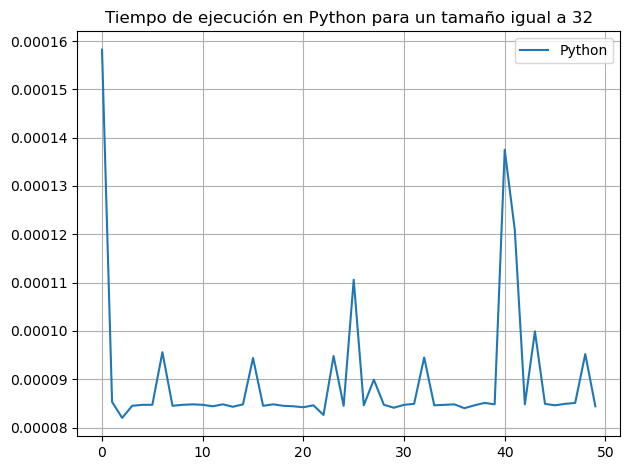

In [51]:
plt.plot(range(veces), t_py_i, label='Python')
plt.legend()
plt.grid(True)
plt.title(f'Tiempo de ejecución en Python para un tamaño igual a {tam}')
plt.tight_layout()

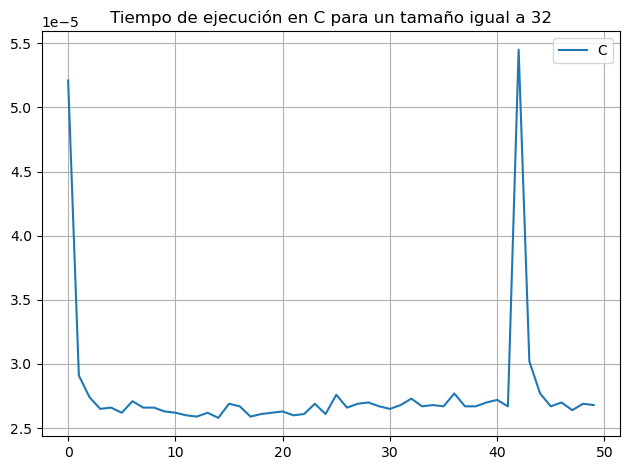

In [52]:
plt.plot(range(veces), t_c_i, label='C')
plt.legend()
plt.grid(True)
plt.title(f'Tiempo de ejecución en C para un tamaño igual a {tam}')
plt.tight_layout()

En ambos casos resulta bastante irregular. ¿Cómo se obtendría entonces el tiempo para un tamaño si se tienen varias mediciones para ese tamaño? Pues, se podría calcular la media aritmética de las mediciones, pero debido a que las mediciones son irregulares, **se empleará la mediana**. La función que calcula la mediana se obtendrá del módulo `statistics`

In [53]:
import statistics

Por ejemplo, si muestra en una gráfica la mediana de las mediciones de Python junto a todas sus mediciones se vería lo siguiente

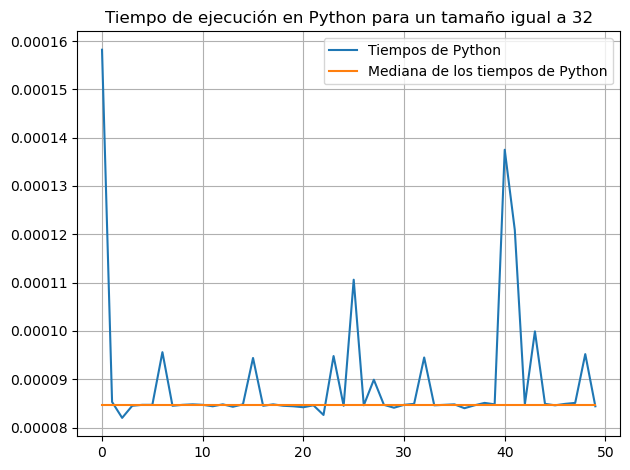

In [54]:
plt.plot(range(veces), t_py_i, label='Tiempos de Python')
plt.plot(range(veces), [statistics.median(t_py_i)]*len(t_py_i), label='Mediana de los tiempos de Python')
plt.legend()
plt.grid(True)
plt.title(f'Tiempo de ejecución en Python para un tamaño igual a {tam}')
plt.tight_layout()

Y con C

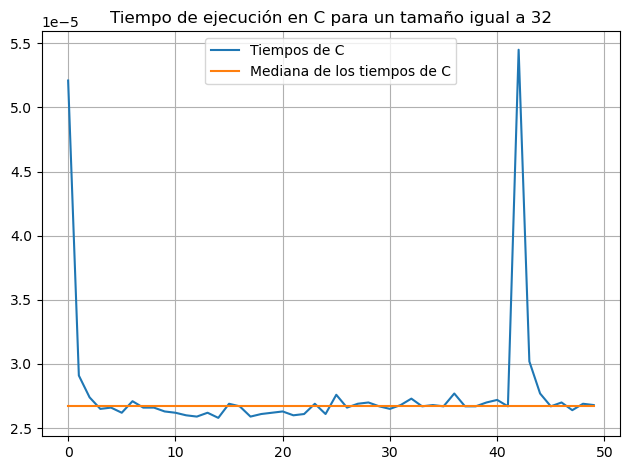

In [55]:
plt.plot(range(veces), t_c_i, label='Tiempos de C')
plt.plot(range(veces), [statistics.median(t_c_i)]*len(t_c_i), label='Mediana de los tiempos de C')
plt.legend()
plt.grid(True)
plt.title(f'Tiempo de ejecución en C para un tamaño igual a {tam}')
plt.tight_layout()

Ahora, lo que es realizar el procedimiento anterior, pero para todos los tamaños.

In [56]:
for tam in tams:
  # se crea el arreglo
  arr = numpy.random.randint(256, size=(tam)).astype(numpy.int32)
  # agumento para la función de Python
  py_arr = arr.copy()
  # argumento para la función de C
  c_arr = arr.copy()
  # lista para las 50 mediciones de Python
  t_py_i = []
  # lista para las 50 mediciones de C
  t_c_i = []

  for i in range(veces):
    # se empieza a medir el tiempo de la función de Python
    tic = time.perf_counter()
    # se llama a la función de Python
    py_ord_burbuja_int(py_arr)
    # se termina de medir el tiempo de la función de Python
    toc = time.perf_counter()
    # se guarda la medición en la lista de Python
    t_py_i.append(toc-tic)

    # se empieza a medir el tiempo de la función de C
    tic = time.perf_counter()
    # se llama a la función de C
    c_ord_burbuja_int(c_arr, c_arr.size)
    # se termina de medir el tiempo de la función de C
    toc = time.perf_counter()
    # se guarda la medición en la lista de C
    t_c_i.append(toc-tic)

  # se guarda la mediana de las 50 mediciones de Python
  t_py.append(statistics.median(t_py_i))
  # se guarda la mediana de las 50 mediciones de C
  t_c.append(statistics.median(t_c_i))

Y con esto ya se tienen gráficas de como varía el tiempo de ejecución de ambas funciones respecto del tamaño del arreglo

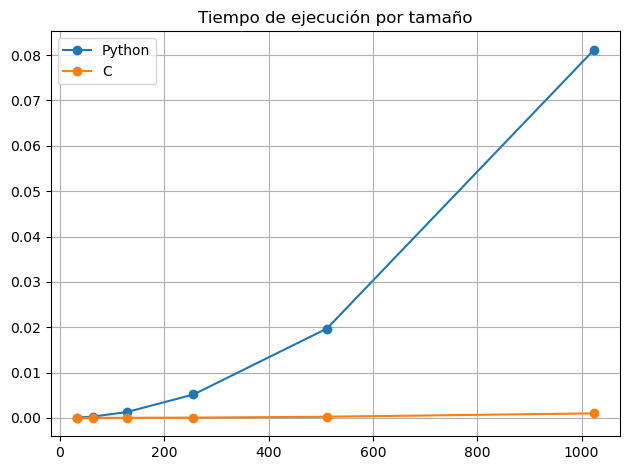

In [57]:
plt.plot(tams, t_py, '-o', label='Python')
plt.plot(tams, t_c, '-o', label='C')
plt.legend()
plt.grid(True)
plt.title('Tiempo de ejecución por tamaño')
plt.tight_layout()

La gráfica de tiempo, por si sola, no parece aportar mucha información. Lo único que se podría afirmar es que C es más rápido que Python. ¿Qué tanto más rápido? Para eso se presenta un gráfico de *Speedup*

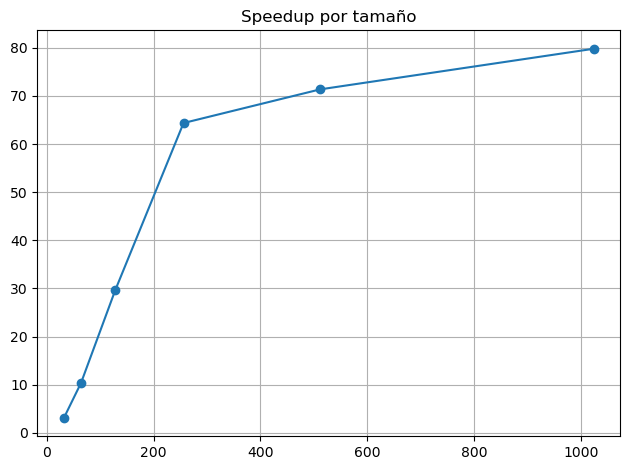

In [58]:
plt.plot(tams, numpy.asarray(t_py)/numpy.asarray(t_c), '-o')
plt.grid(True)
plt.title('Speedup por tamaño')
plt.tight_layout()

Ahora sí se puede tener una idea de que tan más rápido llega a ser C respecto de Python para los tamaños empleados.

## Cuarto ejemplo

El cuarto ejemplo consiste en una modificación del tercer ejemplo. En lugar de modificar el arreglo, los elementos ordenados serán colocados en otro arreglo, el cual será modificado por referencia.

### Codificación

In [59]:
%%file ord_burbuja_2_int.c
#include <string.h>
void ord_burbuja_2_int(int* arr, int* res, int size){
    memcpy(res, arr, size * sizeof(int));
    int i, j, temp;
    for (i = 0; i < size-1; i++) {
        for (j = 0; j < size-1-i; j++) {
            if (res[j] > res[j+1]) {
                temp = res[j];
                res[j] = res[j+1];
                res[j+1] = temp;
            }
        }
    }
}

Writing ord_burbuja_2_int.c


Crear el *object file*

In [60]:
! gcc -c ord_burbuja_2_int.c

Crear la *shared library*

In [61]:
! gcc -shared ord_burbuja_2_int.o -o ord_burbuja_2_int.so

Enlazar con `ctypes`

In [62]:
def ctypes_ord_burbuja_2_int():
    # indicar la ruta de la shared library
    libfile = './ord_burbuja_2_int.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.ord_burbuja_2_int.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        numpy.ctypeslib.ndpointer(dtype=numpy.int32),
        ctypes.c_int
    ]
    
    # funcion configurada
    return lib.ord_burbuja_2_int

In [63]:
c_ord_burbuja_2_int_raw = ctypes_ord_burbuja_2_int()

### Prueba de funcionalidad de `ord_burbuja_2_int`

Como arreglo de entrada se usará el mismo que en el ejemplo anterior, y como arreglo de resultado se creará uno lleno de zeros con las mismas dimensiones que el arreglo de entrada.

In [64]:
arr = numpy.asarray([9, 5, 4, 3, 1, 7, 2, 8]).astype(numpy.int32)
res = numpy.zeros_like(arr)

Luego de usar la función

In [65]:
c_ord_burbuja_2_int_raw(arr, res, arr.size)

7

Se ve que `arr` mantiene su valor original

In [66]:
arr

array([9, 5, 4, 3, 1, 7, 2, 8], dtype=int32)

Y que `res` tiene el arreglo ordenado

In [67]:
res

array([1, 2, 3, 4, 5, 7, 8, 9], dtype=int32)

Ahora lo que haremos será envolver la función para que el proceso de crear el arreglo de resultado se haga de forma transparente al usuario

In [68]:
def c_ord_burbuja_2_int(arr):
    res = numpy.zeros_like(arr)
    c_ord_burbuja_2_int_raw(arr, res, arr.size)
    return res

De esta forma, ya se puede simplemente invocar la función con su entrada e inmediatamente se observará el resultado

In [69]:
c_ord_burbuja_2_int(arr)

array([1, 2, 3, 4, 5, 7, 8, 9], dtype=int32)

### Prueba de precisión de `ord_burbuja_2_int`

Igual que con el ejemplo anterior, se necesita una función de referencia. Por coherencia, también será una forma modificada del ejemplo anterior

In [70]:
def py_ord_burbuja_2_int(arr):
    res = arr.copy()
    n = len(res)
    for i in range(n):
        for j in range(n-i-1):
            if res[j] > res[j+1]:
                res[j], res[j+1] = res[j+1], res[j]
    return res

Con la misma entrada que el ejemplo anterior

In [71]:
l = numpy.asarray([9, 5, 4, 3, 1, 7, 2, 8]).astype(numpy.int32)

Se realiza la prueba

In [72]:
py_res = py_ord_burbuja_2_int(l)

Y se observa el resultado

In [73]:
py_res

array([1, 2, 3, 4, 5, 7, 8, 9], dtype=int32)

Y ahora también se puede medir el error relativo, pero de forma más directa

In [74]:
LA.norm(py_ord_burbuja_2_int(l) - c_ord_burbuja_2_int(l)) / LA.norm(py_ord_burbuja_2_int(l))

0.0

Como puede notar el error relativo también salió `0.0` lo que significa que nuestra función calculó un resultado numericamente idéntico al de Python

### Prueba de tiempo de `ord_burbuja_2_int`

Se repetirán las mismas pruebas que en el ejemplo anterior, por lo que podemos reutilizar los tamaños y las veces, pero se necesitan nuevas listas de tiempos por ser nuevas funciones

In [75]:
t_py_2 = []
t_c_2 = []

La prueba para el primer tamaño

In [76]:
# para el primer tamaño
tam = tams[0]
# se crea el arreglo
arr = numpy.random.randint(256, size=(tam)).astype(numpy.int32)
# agumento para la función de Python
py_arr = arr.copy()
# argumento para la función de C
c_arr = arr.copy()
# lista para las 50 mediciones de Python
t_py_2_i = []
# lista para las 50 mediciones de C
t_c_2_i = []

Las mediciones

In [77]:
for i in range(veces):
  # se empieza a medir el tiempo de la función de Python
  tic = time.perf_counter()
  # se llama a la función de Python
  py_ord_burbuja_2_int(py_arr)
  # se termina de medir el tiempo de la función de Python
  toc = time.perf_counter()
  # se guarda la medición en la lista de Python
  t_py_2_i.append(toc-tic)
  
  # se empieza a medir el tiempo de la función de C
  tic = time.perf_counter()
  # se llama a la función de C
  c_ord_burbuja_2_int(c_arr)
  # se termina de medir el tiempo de la función de C
  toc = time.perf_counter()
  # se guarda la medición en la lista de C
  t_c_2_i.append(toc-tic)

Se grafican las mediciones de Python con la mediana

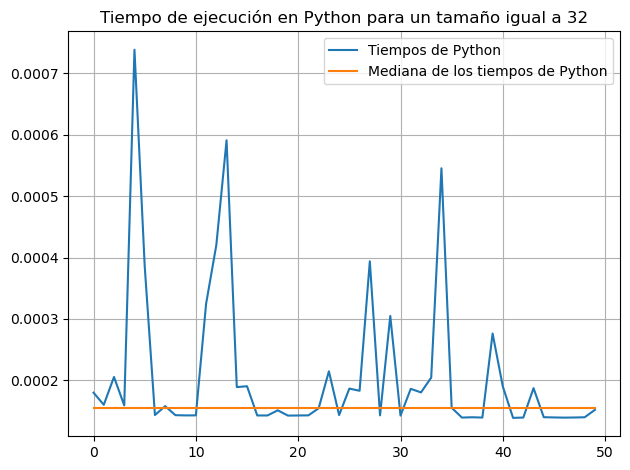

In [78]:
plt.plot(range(veces), t_py_2_i, label='Tiempos de Python')
plt.plot(range(veces), [statistics.median(t_py_2_i)]*len(t_py_2_i), label='Mediana de los tiempos de Python')
plt.legend()
plt.grid(True)
plt.title(f'Tiempo de ejecución en Python para un tamaño igual a {tam}')
plt.tight_layout()

Y también para C

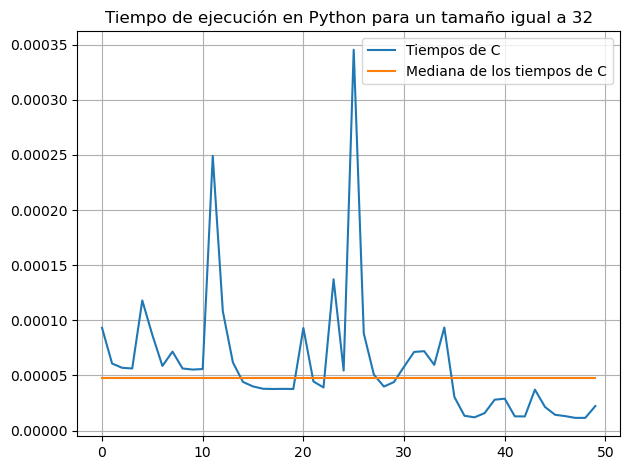

In [79]:
plt.plot(range(veces), t_c_2_i, label='Tiempos de C')
plt.plot(range(veces), [statistics.median(t_c_2_i)]*len(t_c_2_i), label='Mediana de los tiempos de C')
plt.legend()
plt.grid(True)
plt.title(f'Tiempo de ejecución en Python para un tamaño igual a {tam}')
plt.tight_layout()

Ahora se hace este proceso, pero para todos los tamaños

In [80]:
for tam in tams:
  # se crea el arreglo
  arr = numpy.random.randint(256, size=(tam)).astype(numpy.int32)
  # agumento para la función de Python
  py_arr = arr.copy()
  # argumento para la función de C
  c_arr = arr.copy()
  # lista para las 50 mediciones de Python
  t_py_i = []
  # lista para las 50 mediciones de C
  t_c_i = []

  for i in range(veces):
    # se empieza a medir el tiempo de la función de Python
    tic = time.perf_counter()
    # se llama a la función de Python
    py_ord_burbuja_2_int(py_arr)
    # se termina de medir el tiempo de la función de Python
    toc = time.perf_counter()
    # se guarda la medición en la lista de Python
    t_py_i.append(toc-tic)

    # se empieza a medir el tiempo de la función de C
    tic = time.perf_counter()
    # se llama a la función de C
    c_ord_burbuja_2_int(c_arr)
    # se termina de medir el tiempo de la función de C
    toc = time.perf_counter()
    # se guarda la medición en la lista de C
    t_c_i.append(toc-tic)

  # se guarda la mediana de las 50 mediciones de Python
  t_py_2.append(statistics.median(t_py_i))
  # se guarda la mediana de las 50 mediciones de C
  t_c_2.append(statistics.median(t_c_i))

Ahora se mostrarán los tiempos

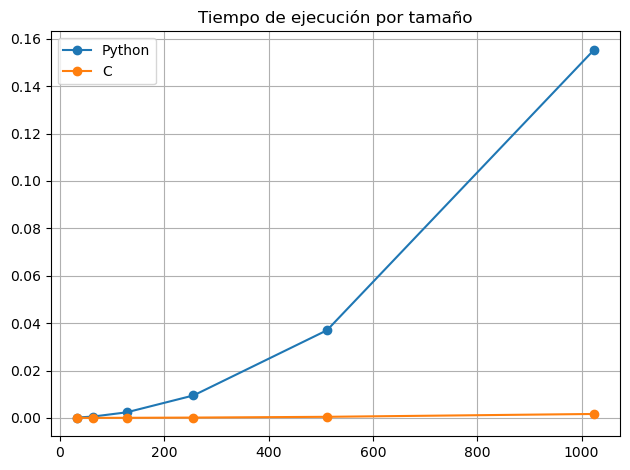

In [81]:
plt.plot(tams, t_py_2, '-o', label='Python')
plt.plot(tams, t_c_2, '-o', label='C')
plt.legend()
plt.grid(True)
plt.title('Tiempo de ejecución por tamaño')
plt.tight_layout()

Y la gráfica de *SpeedUp*

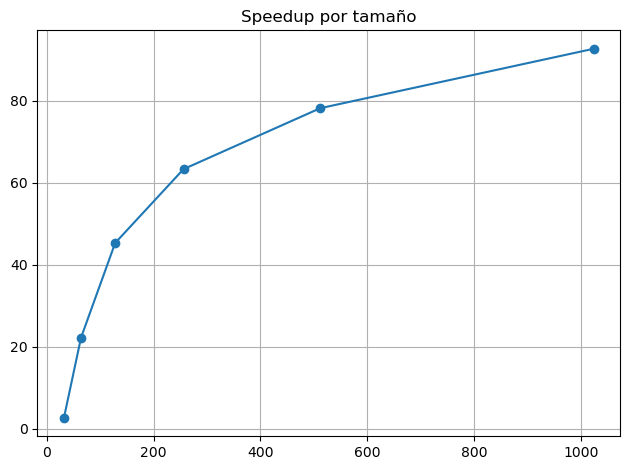

In [82]:
plt.plot(tams, numpy.asarray(t_py_2)/numpy.asarray(t_c_2), '-o')
plt.grid(True)
plt.title('Speedup por tamaño')
plt.tight_layout()

A partir de los resultados en el tercer y cuarto ejemplo. ¿Qué puede notar usted?